In [41]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from datetime import datetime

In [42]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('C:/Users/dheer/Downloads/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution1.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


PermissionError: [Errno 13] Permission denied: 'pollution1.csv'

In [43]:
import pandas as pd
data= pd.read_csv('pollution1.csv')
data.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


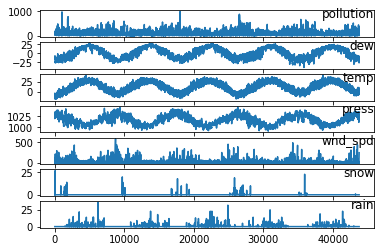

In [44]:
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()


In [45]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder


In [46]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [54]:
dataset = read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
#print(values)
n=365*24
v0=dataset['pollution']
v1=v0[n:]
#v2=v1[:,-1]
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
#ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [55]:
#v2.shape
print(v1[1])


31.0


In [30]:
#splitting into test and train
v1=values[n: ,:]
v2=v1[:,-1]
values=reframed.values
n=365*24
train=values[:n,:]
test=values[n: ,:]
v1=values[n: ,:]
x_tr,y_tr=train[:,:-1],train[:,-1]
x_test,y_test=test[:,:-1],test[:,-1]
v2=v1[:,-1]


In [32]:
#reshaping the values to give input to neural network
x_tr=np.reshape(x_tr,(x_tr.shape[0],x_tr.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [11]:
#building the lstm
regressor=Sequential()

In [12]:
regressor.add(LSTM(units=50,return_sequences=True,input_shape=(x_tr.shape[1],1)))
regressor.add(Dropout(0.2))
#regressor.add(Dropout(0.2))
    
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50,return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))
regressor.compile(optimizer='adam',loss='mean_squared_error')
model=regressor.fit(x_tr,y_tr,epochs=50,batch_size=72,verbose=2,shuffle=False)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
3s - loss: 0.0088
Epoch 2/50
1s - loss: 0.0079
Epoch 3/50
1s - loss: 0.0043
Epoch 4/50
1s - loss: 0.0031
Epoch 5/50
2s - loss: 0.0025
Epoch 6/50
2s - loss: 0.0025
Epoch 7/50
2s - loss: 0.0024
Epoch 8/50
2s - loss: 0.0022
Epoch 9/50
2s - loss: 0.0022
Epoch 10/50
2s - loss: 0.0021
Epoch 11/50
2s - loss: 0.0021
Epoch 12/50
2s - loss: 0.0020
Epoch 13/50
2s - loss: 0.0020
Epoch 14/50
2s - loss: 0.0020
Epoch 15/50
2s - loss: 0.0020
Epoch 16/50
2s - loss: 0.0020
Epoch 17/50
2s - loss: 0.0019
Epoch 18/50
2s - loss: 0.0019
Epoch 19/50
2s - loss: 0.0019
Epoch 20/50
2s - loss: 0.0019
Epoch 21/50
2s - loss: 0.0019
Epoch 22/50
2s - loss: 0.0019
Epoch 23/50
2s - loss: 0.0019
Epoch 24/50

In [67]:
#print(type(v1))
v1=np.array(v1)
v2=v1.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0,1))
v3=sc.fit(v2)

<class 'numpy.ndarray'>


In [70]:
predicted_result=regressor.predict(x_test)
#sc=MinMaxScaler(feature_range=(0,1))
#sc=sc.fit(predicted_result)
predicted_result=sc.inverse_transform(predicted_result)
y_test=y_test.reshape(-1,1)
#y_test=sc.inverse_transform(predicted_result)
#print(v1[1])
print(predicted_result[1])





[31.]
[48.311596]


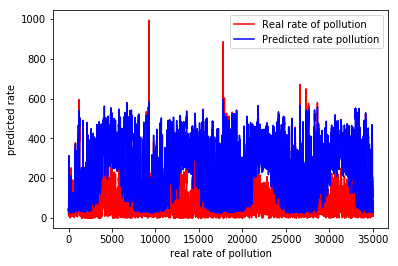

In [72]:
import matplotlib.pyplot as plt
plt.plot(v1,color='red',label='Real rate of pollution')
plt.plot(predicted_result,color='blue',label='Predicted rate pollution')
plt.xlabel('real rate of pollution')
plt.ylabel('predicted rate')
plt.legend()
plt.show()